# Train

Train a model to recognize "on" and "off" speech commands.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import polars as pl

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


## Dataset Configuration

Load the Google Speech Commands dataset. We'll use "on" and "off" as our target classes, and group everything else into "other".

In [2]:
# Configuration
SAMPLE_RATE = 16000  # Speech Commands dataset is 16kHz
DURATION = 1.0  # 1 second context window
N_SAMPLES = int(SAMPLE_RATE * DURATION)

# Mel spectrogram parameters
N_MELS = 40
N_FFT = 512
HOP_LENGTH = 160  # 10ms hop at 16kHz

# Dataset path
DATASET_PATH = Path.home() / "datasets"
DATASET_PATH.mkdir(exist_ok=True)

# Target labels
TARGET_LABELS = ["on", "off"]
LABEL_MAP = {"on": 0, "off": 1, "other": 2}
NUM_CLASSES = 3

In [3]:
# Check if dataset exists, download if not
speech_commands_path = DATASET_PATH / "SpeechCommands" / "speech_commands_v0.02"

if speech_commands_path.exists():
    print(f"Dataset found at {speech_commands_path}")
    download = False
else:
    print(f"Dataset not found. Will download to {DATASET_PATH}")
    download = True

# Load dataset using torchaudio
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=str(DATASET_PATH), download=download, subset="training"
)

val_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=str(DATASET_PATH), download=False, subset="validation"
)

test_dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root=str(DATASET_PATH), download=False, subset="testing"
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Dataset found at /Users/Brian/datasets/SpeechCommands/speech_commands_v0.02
Training samples: 84843
Validation samples: 9981
Test samples: 11005


## Custom Dataset Wrapper

Wrap the Speech Commands dataset to:
1. Map labels to our 3-class scheme (on, off, other)
2. Pad/trim audio to exactly 1 second
3. Convert to mel spectrogram

In [4]:
class SpeechCommandsWrapper(Dataset):
    """Wrapper around SPEECHCOMMANDS dataset for our 3-class task."""

    def __init__(self, dataset, transform=None, balance_classes=False):
        self.dataset = dataset
        self.transform = transform

        # Create mel spectrogram transform
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
        )

        # Optional: balance classes by subsampling "other" class
        if balance_classes:
            self._create_balanced_indices()
        else:
            self.indices = list(range(len(dataset)))

    def _create_balanced_indices(self):
        """Balance dataset by subsampling 'other' class."""
        # CSV file path for caching labels
        csv_path = (
            DATASET_PATH
            / "SpeechCommands"
            / "speech_commands_v0.02"
            / "train_labels.csv"
        )

        if csv_path.exists():
            # Load from CSV
            print(f"Loading labels from {csv_path}")
            df = pl.read_csv(csv_path)
        else:
            # Create CSV by iterating through dataset
            print(f"Creating labels CSV at {csv_path}")
            labels = []
            indices = []

            for i in tqdm(range(len(self.dataset)), desc="Creating labels CSV"):
                _, _, label, *_ = self.dataset[i]
                labels.append(label)
                indices.append(i)

            # Save to CSV
            csv_path.parent.mkdir(parents=True, exist_ok=True)
            df = pl.DataFrame({"Label": labels, "Index": indices})
            df.write_csv(csv_path)
            print(f"Saved labels CSV to {csv_path}")

        # Organize indices by label
        on_indices = df.filter(pl.col("Label") == "on")["Index"].to_list()
        off_indices = df.filter(pl.col("Label") == "off")["Index"].to_list()
        other_indices = df.filter(~pl.col("Label").is_in(["on", "off"]))[
            "Index"
        ].to_list()

        # Subsample 'other' to match combined on+off count
        target_count = len(on_indices) + len(off_indices)
        other_indices = list(
            np.random.choice(
                other_indices, min(target_count, len(other_indices)), replace=False
            )
        )

        self.indices = on_indices + off_indices + other_indices
        np.random.shuffle(self.indices)

        print(
            f"Balanced: on={len(on_indices)}, off={len(off_indices)}, other={len(other_indices)}"
        )

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        waveform, sample_rate, label, *_ = self.dataset[real_idx]

        # Resample if necessary
        if sample_rate != SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sample_rate, SAMPLE_RATE)
            waveform = resampler(waveform)

        # Pad or trim to 1 second
        if waveform.shape[1] < N_SAMPLES:
            padding = N_SAMPLES - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            waveform = waveform[:, :N_SAMPLES]

        # Convert to mel spectrogram
        mel = self.mel_spec(waveform)

        # Convert to log scale (add small epsilon to avoid log(0))
        mel = torch.log(mel + 1e-9)

        # Apply additional transforms if any
        if self.transform:
            mel = self.transform(mel)

        # Map label to class index
        if label in TARGET_LABELS:
            class_idx = LABEL_MAP[label]
        else:
            class_idx = LABEL_MAP["other"]

        return mel, class_idx

In [5]:
# Create wrapped datasets with class balancing for training
train_wrapped = SpeechCommandsWrapper(train_dataset, balance_classes=True)
val_wrapped = SpeechCommandsWrapper(val_dataset, balance_classes=False)
test_wrapped = SpeechCommandsWrapper(test_dataset, balance_classes=False)

# Create data loaders
# Note: num_workers=0 to avoid multiprocessing issues with custom classes in notebooks
BATCH_SIZE = 64

train_loader = DataLoader(
    train_wrapped, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_wrapped, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
test_loader = DataLoader(
    test_wrapped, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading labels from /Users/Brian/datasets/SpeechCommands/speech_commands_v0.02/train_labels.csv
Balanced: on=3086, off=2970, other=6056
Train batches: 190
Val batches: 156
Test batches: 172


Mel spectrogram shape: torch.Size([1, 40, 101])
Label: 1 (off)


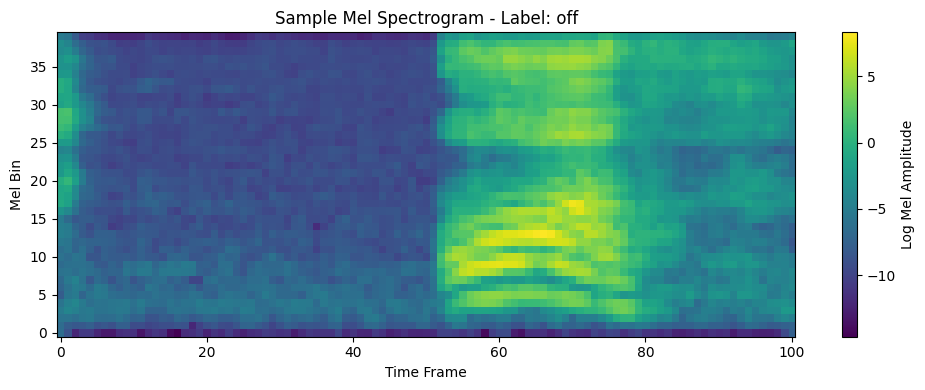

In [6]:
# Visualize a sample
mel, label = train_wrapped[0]
print(f"Mel spectrogram shape: {mel.shape}")  # Should be (1, n_mels, time_frames)
print(f"Label: {label} ({['on', 'off', 'other'][label]})")

plt.figure(figsize=(10, 4))
plt.imshow(mel.squeeze().numpy(), aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Log Mel Amplitude")
plt.xlabel("Time Frame")
plt.ylabel("Mel Bin")
plt.title(f"Sample Mel Spectrogram - Label: {['on', 'off', 'other'][label]}")
plt.tight_layout()
plt.show()

## Model Definition

A small CNN designed for embedded deployment. The architecture uses:
- Depthwise separable convolutions for efficiency
- Small filter sizes and limited channels
- Global average pooling to reduce parameters

In [11]:
class DepthwiseSeparableConv(nn.Module):
    """Depthwise separable convolution for efficiency."""

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False,
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class SmallSpeechCNN(nn.Module):
    """
    Small CNN for speech command recognition.

    Input: (batch, 1, n_mels, time_frames) - mel spectrogram
    Output: (batch, num_classes) - logits for each class
    """

    def __init__(self, num_classes=3):
        super().__init__()

        # Initial conv layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # Reduce dimensions by 2
        )

        # Depthwise separable conv blocks
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv(16, 20, kernel_size=3, padding=1), nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            DepthwiseSeparableConv(20, 24, kernel_size=3, padding=1), nn.MaxPool2d(2, 2)
        )

        self.conv4 = nn.Sequential(
            DepthwiseSeparableConv(24, 24, kernel_size=3, padding=1), nn.MaxPool2d(2, 2)
        )

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(24, num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [12]:
# Instantiate model
model = SmallSpeechCNN(num_classes=NUM_CLASSES).to(device)

# Print model summary
print(f"Total trainable parameters: {model.count_parameters():,}")

# Test forward pass
sample_mel, _ = train_wrapped[0]
sample_batch = sample_mel.unsqueeze(0).to(device)  # Add batch dimension
output = model(sample_batch)
print(f"Input shape: {sample_batch.shape}")
print(f"Output shape: {output.shape}")
print(f"Output logits: {output.detach().cpu().numpy()}")

Total trainable parameters: 2,303
Input shape: torch.Size([1, 1, 40, 101])
Output shape: torch.Size([1, 3])
Output logits: [[-0.84175044  0.5084615  -0.39536917]]


## Training

Train the model with cross-entropy loss and Adam optimizer.

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for mels, labels in tqdm(loader, desc="Training", leave=False):
        mels, labels = mels.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(mels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * mels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, 100.0 * correct / total


def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for mels, labels in tqdm(loader, desc="Evaluating", leave=False):
            mels, labels = mels.to(device), labels.to(device)

            outputs = model(mels)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * mels.size(0)
            _, predicted = outputs.softmax(1).max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / total, 100.0 * correct / total, all_preds, all_labels

In [14]:
# Training configuration
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

# Training history
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_loss = None
best_model_state = None

print("Starting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epoch"):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Save best model
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    print(
        f"Epoch {epoch + 1:2d}/{NUM_EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%"
    )

print(f"\nBest validation loss: {best_val_loss:.2f}%")

Starting training...


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  1/30 | Train Loss: 0.9905, Acc: 50.38% | Val Loss: 0.5576, Acc: 91.32%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  2/30 | Train Loss: 0.7076, Acc: 71.96% | Val Loss: 0.5063, Acc: 81.63%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  3/30 | Train Loss: 0.5372, Acc: 80.46% | Val Loss: 0.2571, Acc: 92.46%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  4/30 | Train Loss: 0.4331, Acc: 84.49% | Val Loss: 0.2852, Acc: 90.59%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  5/30 | Train Loss: 0.3651, Acc: 86.79% | Val Loss: 0.1481, Acc: 95.40%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  6/30 | Train Loss: 0.3202, Acc: 88.87% | Val Loss: 0.1329, Acc: 95.55%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  7/30 | Train Loss: 0.3009, Acc: 89.37% | Val Loss: 0.3759, Acc: 86.24%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  8/30 | Train Loss: 0.2764, Acc: 90.17% | Val Loss: 0.1404, Acc: 95.30%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch  9/30 | Train Loss: 0.2582, Acc: 91.00% | Val Loss: 0.1953, Acc: 93.11%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.2502, Acc: 91.03% | Val Loss: 0.2119, Acc: 92.32%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 0.2230, Acc: 92.08% | Val Loss: 0.1463, Acc: 94.81%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 0.2257, Acc: 92.03% | Val Loss: 0.1938, Acc: 93.03%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 0.2196, Acc: 92.02% | Val Loss: 0.1678, Acc: 93.90%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 0.2136, Acc: 92.18% | Val Loss: 0.1305, Acc: 95.25%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.2074, Acc: 92.49% | Val Loss: 0.1245, Acc: 95.69%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 0.2059, Acc: 92.50% | Val Loss: 0.1155, Acc: 96.12%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 0.1970, Acc: 92.85% | Val Loss: 0.2369, Acc: 91.65%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 0.2008, Acc: 92.67% | Val Loss: 0.1877, Acc: 93.37%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 0.1985, Acc: 92.86% | Val Loss: 0.1125, Acc: 96.07%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.1875, Acc: 93.11% | Val Loss: 0.1502, Acc: 94.74%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 0.1840, Acc: 93.45% | Val Loss: 0.1667, Acc: 94.01%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 0.1817, Acc: 93.39% | Val Loss: 0.1895, Acc: 93.48%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 0.1783, Acc: 93.38% | Val Loss: 0.1847, Acc: 93.50%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 0.1749, Acc: 93.58% | Val Loss: 0.1309, Acc: 95.33%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.1744, Acc: 93.63% | Val Loss: 0.1801, Acc: 93.63%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 26/30 | Train Loss: 0.1719, Acc: 93.97% | Val Loss: 0.0972, Acc: 96.76%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 27/30 | Train Loss: 0.1729, Acc: 93.65% | Val Loss: 0.1824, Acc: 93.56%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 28/30 | Train Loss: 0.1655, Acc: 93.91% | Val Loss: 0.1684, Acc: 94.03%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 29/30 | Train Loss: 0.1643, Acc: 94.16% | Val Loss: 0.1256, Acc: 95.56%


Training:   0%|          | 0/190 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.1665, Acc: 93.96% | Val Loss: 0.1796, Acc: 93.71%

Best validation loss: 0.10%


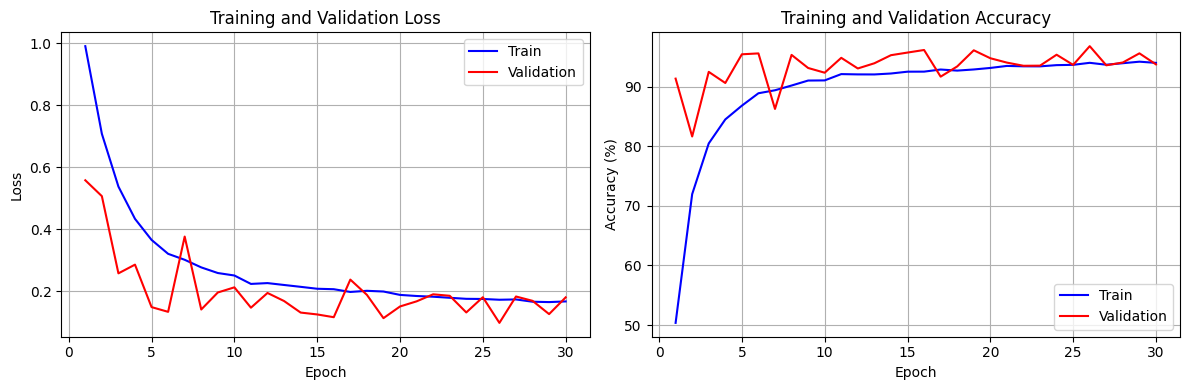

In [15]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

epochs = range(1, len(history["train_loss"]) + 1)

ax1.plot(epochs, history["train_loss"], "b-", label="Train")
ax1.plot(epochs, history["val_loss"], "r-", label="Validation")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, history["train_acc"], "b-", label="Train")
ax2.plot(epochs, history["val_acc"], "r-", label="Validation")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Evaluation

Load the best model and evaluate on the test set.

In [16]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating:   0%|          | 0/172 [00:00<?, ?it/s]

Test Loss: 0.1577
Test Accuracy: 94.25%


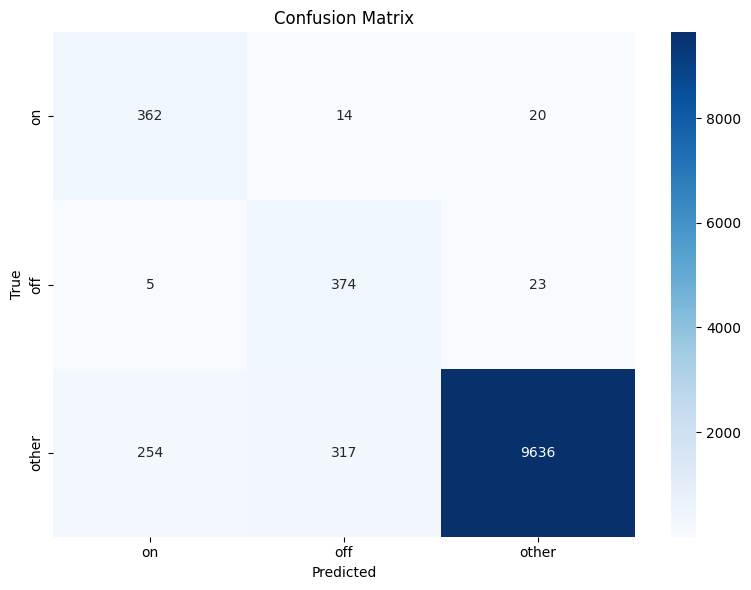


Classification Report:
              precision    recall  f1-score   support

          on       0.58      0.91      0.71       396
         off       0.53      0.93      0.68       402
       other       1.00      0.94      0.97     10207

    accuracy                           0.94     11005
   macro avg       0.70      0.93      0.79     11005
weighted avg       0.96      0.94      0.95     11005



In [17]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ["on", "off", "other"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

## Save Model

Save the trained model for later use or deployment.

In [18]:
# Save model
MODEL_DIR = Path("../checkpoints")
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "speech_cnn.pt"
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "model_config": {
            "n_mels": N_MELS,
            "num_classes": NUM_CLASSES,
        },
        "audio_config": {
            "sample_rate": SAMPLE_RATE,
            "n_fft": N_FFT,
            "hop_length": HOP_LENGTH,
            "n_mels": N_MELS,
            "duration": DURATION,
        },
        "label_map": LABEL_MAP,
        "test_accuracy": test_acc,
    },
    model_path,
)

print(f"Model saved to {model_path}")
print(f"Model size: {model_path.stat().st_size / 1024:.2f} KB")

Model saved to ../checkpoints/speech_cnn.pt
Model size: 19.55 KB


In [19]:
# Print final summary
print("=" * 50)
print("TRAINING COMPLETE")
print("=" * 50)
print("\nModel Architecture: SmallSpeechCNN")
print(f"Total Parameters: {model.count_parameters():,}")
print("\nAudio Configuration:")
print(f"  - Sample Rate: {SAMPLE_RATE} Hz")
print(f"  - Duration: {DURATION} seconds")
print(f"  - Mel Bins: {N_MELS}")
print(f"  - FFT Size: {N_FFT}")
print(f"  - Hop Length: {HOP_LENGTH}")
print(f"\nClasses: {class_names}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("\nSaved files:")
print(f"  - PyTorch: {model_path}")

TRAINING COMPLETE

Model Architecture: SmallSpeechCNN
Total Parameters: 2,303

Audio Configuration:
  - Sample Rate: 16000 Hz
  - Duration: 1.0 seconds
  - Mel Bins: 40
  - FFT Size: 512
  - Hop Length: 160

Classes: ['on', 'off', 'other']
Test Accuracy: 94.25%

Saved files:
  - PyTorch: ../checkpoints/speech_cnn.pt
